In [36]:
import os
import time
from glob import glob

import cv2
import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Input
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.models import Sequential, load_model
import matplotlib.image as mpimg



pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)

np.random.seed(42)

# Exploratory Data Analysis (EDA) Plan

In this section, we will perform exploratory data analysis (EDA) to achieve the following objectives:

1. **Understand Data Distribution**: Visualize and summarize the distribution of the labels to identify any skewness or abnormalities.
2. **Identify Missing Values**: Detect missing values in the dataset and understand their patterns and possible implications.
3. **Visualize Sample Images**: Display a few sample images to get a sense of the data and its quality.
4. **Explore Image Properties**: Examine properties such as image dimensions and color channels.

The insights gained from EDA will inform our data cleaning and preprocessing steps, ensuring that our dataset is well-prepared for modeling.



In [37]:
def get_df_for_eda(train_images_dir, train_labels_path):
    """
    Load the data and merge it with labels.

    Returns:
        pd.DataFrame: DataFrame containing image paths and corresponding labels.
    """
    df_ = pd.DataFrame({
        'path': glob(os.path.join(train_images_dir, '*.tif'))
    })
    df_['id'] = df_.path.map(lambda x: os.path.basename(x).split(".")[0])
    labels = pd.read_csv(train_labels_path)
    df_ = df_.merge(labels, on="id")
    return df_

eda_df = get_df_for_eda('data/train', 'data/train_labels.csv')


### Visualize Sample Images

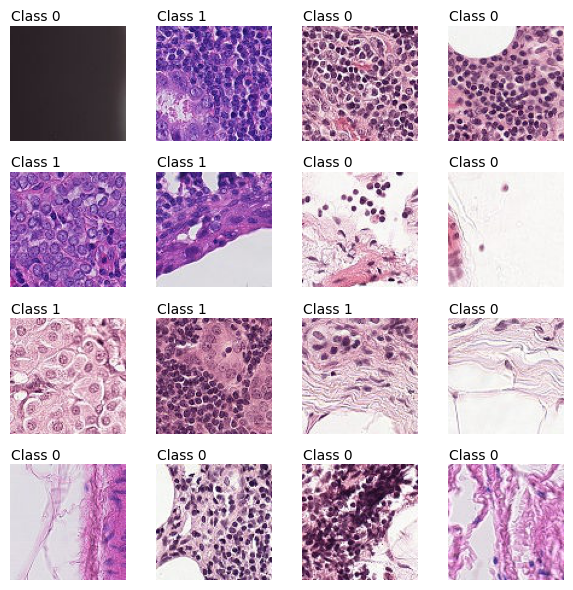

In [38]:
def visualize_sample_images(train_labels_path, train_images_dir, sample_size=16):
    """
    Visualize a sample of images from the training dataset along with their labels.

    Parameters:
    - train_labels_path (str): Path to the CSV file containing image labels.
    - train_images_dir (str): Directory containing the training images.
    - sample_size (int): Number of sample images to display. Default is 16.

    """
    # Load the training labels
    train_labels_df = pd.read_csv(train_labels_path)

    # Randomly sample the specified number of images and reset the index
    sample = train_labels_df.sample(n=sample_size).reset_index()

    # Set up the plot with a specified figure size
    plt.figure(figsize=(6, 6))

    # Iterate over each sampled row to plot the images
    for i, row in sample.iterrows():
        # Load the image using its ID from the CSV file
        img = mpimg.imread(os.path.join(train_images_dir, f'{row.id}.tif'))
        
        # Get the label associated with the image
        label = row.label

        # Create a subplot for each image
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        
        # Display the label below each image
        plt.text(0, -5, f'Class {label}', color='k')
        
        # Turn off the axis for a cleaner look
        plt.axis('off')

    # Adjust the layout to avoid overlap
    plt.tight_layout()

visualize_sample_images('data/train_labels.csv', 'data/train')

### Analyze Data Distributions

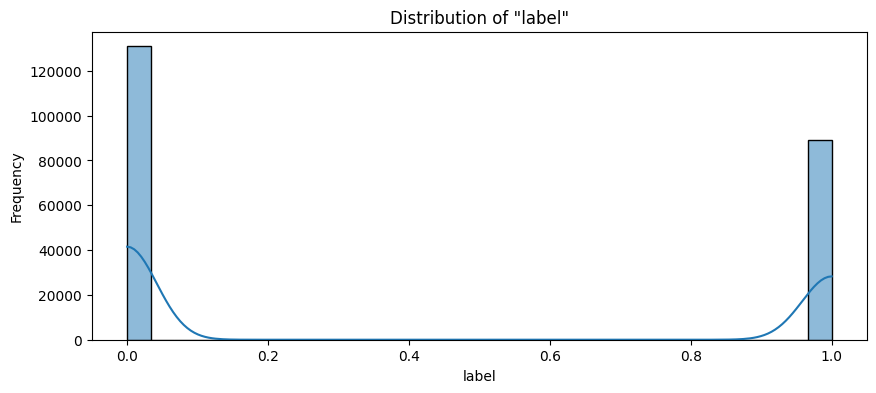

In [39]:
def analyze_image_data(df):
    """
    Analyze the image data by printing image dimensions, color channels,
    and plotting the distribution of labels in the training set.

    Parameters:
    - train_images_dir (str): Directory containing the training images.
    - train_labels_path (str): Path to the CSV file containing image labels.
    """
    plt.figure(figsize=(10, 4))
    sns.histplot(df["label"].dropna(), kde=True, bins=30)
    plt.title('Distribution of "label"')
    plt.xlabel("label")
    plt.ylabel('Frequency')
    plt.show()

# Example usage
analyze_image_data(eda_df)

In [40]:
def summarize_missing_values(df):
        """
        Detect and summarize missing values in the dataset.
        """
        missing_values = df.isnull().sum()
        missing_values_percent = (missing_values / len(df)) * 100
        missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percent Missing': missing_values_percent})
        missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
        return missing_summary

summarize_missing_values(eda_df)

,Missing Values,Percent Missing


### EDA Results and Data Cleaning Plan

After performing the exploratory data analysis (EDA), we obtained the following key insights:

1. **Label Distribution**: The labels are fairly balanced, indicating that class imbalance handling is not be necessary.
2. **Missing Values**: We did not find missing values in the dataset. So we do not need to deal with null data points.
3. **Sample Image Quality**: The sample images appear to be of good quality, suggesting image preprocessing is not necessary.

Based on these findings, our plan for data cleaning includes:

1. **Handling Missing Values**: N/A
2. **Balancing Classes**: N/A
3. **Image Preprocessing**: For experimentation with improving our models, we will apply preprocessing steps such as resizing images to a consistent dimension, normalizing pixel values, and data augmentation techniques (e.g., rotations, flips) to improve model robustness.

These steps will ensure that our dataset is clean, well-prepared, and ready for the modeling process.

# Create a Custom Keras Callback to checkpoint epochs

In [41]:
class EpochSaver(Callback):
    """
    Custom callback to save the current epoch number to a file.
    """
    def __init__(self, filepath):
        super(EpochSaver, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filepath, 'w') as f:
            f.write(str(epoch + 1))  # Save next epoch number

# Create the model training and prediction code in a ModelTrainer class

In [42]:
class ModelTrainer:
    def __init__(self, path, train_path, test_path, batch_size=32, epochs=3, disable_gpu=True, resume=False):
        """
        Initialize the ModelTrainer with paths, batch size, and epochs.

        Args:
            path (str): Base path to the data directory.
            train_path (str): Path to the training data directory.
            test_path (str): Path to the testing data directory.
            batch_size (int, optional): Number of samples per batch. Defaults to 32.
            epochs (int, optional): Number of epochs to train the model. Defaults to 3.
            disable_gpu (bool, optional): Flag to disable GPU usage. Defaults to True.
            resume (bool, optional): Flag to resume training from the last checkpoint. Defaults to False.
        """
        self.path = path
        self.train_path = train_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.epochs = epochs
        self.resume = resume
        self.current_epoch = 0
        self.epoch_file = "current_epoch.txt"

        if disable_gpu:
            self.disable_gpu()

        self.model = self.build_model()

        if self.resume:
            self.load_epoch()

    @staticmethod
    def disable_gpu():
        """
        Disable GPU for TensorFlow to ensure the model runs on CPU.
        """
        try:
            tf.config.set_visible_devices([], 'GPU')
            visible_devices = tf.config.get_visible_devices()
            for device in visible_devices:
                print("Disabling device:", device)
                assert device.device_type != 'GPU'
        except Exception as e:
            print("Error disabling GPU:", e)

    def get_df(self):
        """
        Load the data and merge it with labels.

        Returns:
            pd.DataFrame: DataFrame containing image paths and corresponding labels.
        """
        print("-" * 20, "\nLoading data")

        df_ = pd.DataFrame({
            'path': glob(os.path.join(self.train_path, '*.tif'))
        })
        df_['id'] = df_.path.map(lambda x: os.path.basename(x).split(".")[0])
        labels = pd.read_csv(os.path.join(self.path, "train_labels.csv"))
        df_ = df_.merge(labels, on="id")

        print("-" * 20, "\nData loaded")
        print(df_.head())

        return df_

    @staticmethod
    def load_data(df_):
        """
        Load image data and labels into numpy arrays.

        Args:
            df_ (pd.DataFrame): DataFrame containing image paths and labels.

        Returns:
            np.ndarray: Array of image data.
            np.ndarray: Array of labels.
        """
        X = np.zeros([df_.shape[0], 96, 96, 3], dtype=np.uint8)
        y = np.squeeze(df_[['label']].to_numpy())
        for i, (index, row) in enumerate(df_.iterrows()):
            X[i] = cv2.imread(row['path'])
        return X, y

    def build_model(self):
        """
        Build and compile the CNN model.

        Returns:
            keras.models.Sequential: Compiled CNN model.
        """
        if self.resume and os.path.exists("model_checkpoint.keras"):
            print("Loading model from checkpoint...")
            return load_model("model_checkpoint.keras")
        else:
            kernel_size = (3, 3)
            pool_size = (2, 2)
            first_filters = 32
            second_filters = 64
            third_filters = 128
            dropout_conv = 0.3
            dropout_dense = 0.5

            model = Sequential()
            model.add(Input(shape=(96, 96, 3)))

            model.add(Conv2D(first_filters, kernel_size))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Conv2D(first_filters, kernel_size, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=pool_size))
            model.add(Dropout(dropout_conv))

            model.add(Conv2D(second_filters, kernel_size, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Conv2D(second_filters, kernel_size, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=pool_size))
            model.add(Dropout(dropout_conv))

            model.add(Conv2D(third_filters, kernel_size, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Conv2D(third_filters, kernel_size, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=pool_size))
            model.add(Dropout(dropout_conv))

            model.add(Flatten())
            model.add(Dense(256, use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Dropout(dropout_dense))

            model.add(Dense(1, activation="sigmoid"))

            model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001),
                          metrics=['accuracy'])
            return model

    def load_epoch(self):
        """
        Load the current epoch number from the epoch file.
        """
        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.current_epoch = int(f.read())
                print(f"Resuming from epoch {self.current_epoch}")

    def train_model(self, X, y, split_idx):
        """
        Train the model on the given data.

        Args:
            X (np.ndarray): Array of image data.
            y (np.ndarray): Array of labels.
            split_idx (int): Index to split data into training and validation sets.
        """
        callbacks = [
            ModelCheckpoint("model_checkpoint.keras", save_best_only=True, monitor='val_loss', mode='min'),
            EpochSaver(self.epoch_file),
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        ]

        # Create tf.data dataset for better performance and lower memory usage
        train_dataset = tf.data.Dataset.from_tensor_slices((X[:split_idx], y[:split_idx]))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(self.batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        val_dataset = tf.data.Dataset.from_tensor_slices((X[split_idx:], y[split_idx:]))
        val_dataset = val_dataset.batch(self.batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        self.model.fit(
            train_dataset,
            initial_epoch=self.current_epoch,  # Start from the current epoch
            epochs=self.epochs,  # Total epochs to train
            validation_data=val_dataset,
            callbacks=callbacks
        )

    def predict_and_save(self, file_batch=5000):
        """
        Predict on the test data and save the results to a CSV file.

        Args:
            file_batch (int, optional): Number of files to process in each batch. Defaults to 5000.
        """
        base_test_dir = os.path.join(self.path, 'test/')
        test_files = glob(os.path.join(base_test_dir, '*.tif'))
        submission = pd.DataFrame()
        max_idx = len(test_files)

        for idx in range(0, max_idx, file_batch):
            print("Indexes: %i - %i" % (idx, idx + file_batch))
            test_df = pd.DataFrame({
                'path': test_files[idx:idx + file_batch]
            })
            test_df['id'] = test_df.path.map(lambda x: os.path.basename(x).split(".")[0])
            test_df['image'] = test_df['path'].map(cv2.imread)
            K_test = np.stack(test_df["image"].values)
            predictions = self.model.predict(K_test, verbose=1)
            test_df['label'] = predictions
            submission = pd.concat([submission, test_df[["id", "label"]]])

        print(submission.head())
        submission.to_csv("submission.csv", index=False, header=True)

    def run(self, N):
        """
        Execute the full training and prediction pipeline.

        Args:
            N (int, optional): Number of samples to use. If None, use all available samples. Defaults to None.
        """
        start_time = time.time()

        df = self.get_df()
        if N is None:
            N = df["path"].size
        print(f"Total items in the training set: {N}")
        X, y = self.load_data(df_=df)
        training_portion = 0.8
        split_idx = int(np.round(training_portion * y.shape[0]))

        idx = np.arange(y.shape[0])
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Only train if the current epoch is less than the total epochs specified
        if self.current_epoch < self.epochs:
            self.train_model(X, y, split_idx)

        # Proceed to prediction regardless of whether training was needed or not
        self.predict_and_save()

        end_time = time.time()
        total_time = end_time - start_time
        print(f"Total execution time: {total_time:.2f} seconds")

In [43]:
path = "data/"
train_path = os.path.join(path, 'train/')
test_path = os.path.join(path, 'test/')

model_trainer = ModelTrainer(path, train_path, test_path, epochs=4, disable_gpu=True, resume=True)
model_trainer.run(N=None)

Disabling device: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Loading model from checkpoint...
Resuming from epoch 4
-------------------- 
Loading data
-------------------- 
Data loaded
                                                path                                        id  label
0  data/train/f0c2a0b8ef3024f407fa97d852d49be0215...  f0c2a0b8ef3024f407fa97d852d49be0215cafe0      0
1  data/train/99ef485f205645918613cd04281098daa7c...  99ef485f205645918613cd04281098daa7c17819      1
2  data/train/e2612e173abd0e8bb54a3c3db3f264b63d8...  e2612e173abd0e8bb54a3c3db3f264b63d80bffb      1
3  data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1...  6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0      0
4  data/train/9c043ab2adadfeb758c71d21432fccd3e43...  9c043ab2adadfeb758c71d21432fccd3e43565c0      1
Total items in the training set: 220025
Indexes: 0 - 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
Indexes: 5000 - 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step
Indexes: 10000 - 